<a href="https://colab.research.google.com/github/OdysseusPolymetis/digital_classics_course/blob/main/3_counter_latin_grec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Quelques représentations statistiques de base**

Voici quelques représentations graphiques auxquelles on peut réfléchir pour comparer lexicalement plusieurs auteurs.

In [1]:
from collections import Counter

In [2]:
!pip install stanza

In [3]:
import stanza
import string

## **Quelques statistiques de base**

Sur vos propres textes, quelques visualisations statistiques.
<br>Vous devez, dans un premier temps, vous resservir du premier notebook que nous avons fait (imports cltk), et télécharger le zip final qui contiendra vos données. Une fois ce zip obtenu, dézippez sur votre ordinateur, et parcourez-le jusqu'à tomber sur le dossier des données qui vous intéressent. Cela fait, compressez le en le nommant corpus.zip.
<br>Dans la cellule suivante, importer le zip que vous venez de créer.

In [46]:
from google.colab import files
uploaded = files.upload()

Saving corpus.zip to corpus.zip


La cellule qui suit permet de dézipper. À l'issue de cette cellule, vous devez obtenir un dossier avec vos données. Certaines seront en xml, d'autres en txt. Je n'aurai peut-être pas tout testé et vérifié.

In [ ]:
!unzip /content/corpus.zip -d /content/

In [55]:
import os
from lxml import etree

base_dir = "/content/corpus"
texts = []

In [56]:
def extract_body_text_from_xml(path):

    parser = etree.XMLParser(recover=True, resolve_entities=False)

    with open(path, "rb") as f:
        tree = etree.parse(f, parser)

    root = tree.getroot()

    body = root.find('.//{*}body')
    if body is None:
        return ""


    text = " ".join(body.itertext())

    text = " ".join(text.split())
    return text

In [48]:
def fast_vocab_stats(file_path, text, nlp, max_chars=200_000):
    print("Nom du fichier traité : "+file_path)

    paragraphs = text.split('\n')
    chunks = []
    current = []
    current_len = 0

    for p in paragraphs:
        length = len(p) + 1
        if current and current_len + length > max_chars:
            chunks.append('\n'.join(current))
            current = [p]
            current_len = length
        else:
            current.append(p)
            current_len += length
    if current:
        chunks.append('\n'.join(current))

    total = 0
    lemmas_set = set()

    for chunk in chunks:
        if not chunk.strip():
            continue
        doc = nlp(chunk)
        for sentence in doc.sentences:
            for word in sentence.words:
                if word.lemma:
                    total += 1
                    lemmas_set.add(word.lemma)

    return total, len(lemmas_set)

Ici, en fonction de ce que vous aurez choisi (du grec ou du latin), choisissez `grc` ou `la` dans la cellule ci-dessous.

In [49]:
nlp_stanza = stanza.Pipeline(
    'la',
    processors='tokenize,pos,lemma',
    use_gpu=True,
    tokenize_batch_size=5000,
    pos_batch_size=2000,
    lemma_batch_size=2000,
    verbose=False,
)

Cette partie-là peut mettre pas mal de temps, soyez patients (ça va dépendre de l'auteur que vous aurez soumis).
<br>Pour tout Cicéron de la Latin Library, j'ai mis 8 minutes. Vous pouvez, si vous voulez que ce soit moins long, créer un dossier vous-même, mettre les textes que vous voulez dedans, et le compresser ensuite.

In [57]:
resultats = []
for root_dir, subdirs, files in os.walk(base_dir):
    for fname in files:
        lower = fname.lower()
        fpath = os.path.join(root_dir, fname)

        texte = None

        if lower.endswith(".txt"):
            try:
                with open(fpath, "r", encoding="utf-8", errors="ignore") as f:
                    texte = f.read()
            except Exception as e:
                print(f"Erreur lecture TXT pour {fpath}: {e}")

        elif lower.endswith(".xml") and "eng" not in lower:
            texte = extract_body_text_from_xml(fpath)

        if not texte:
            continue
        titre = os.path.relpath(fpath, base_dir)
        total_lemmes, uniques_lemmes = fast_vocab_stats(fpath, texte, nlp_stanza)
        resultats.append((titre, total_lemmes, uniques_lemmes))

Nom du fichier traité : /content/corpus/vergil/serv.verg.ecl_lat.xml
Nom du fichier traité : /content/corpus/vergil/verg.ecl_lat.xml
Nom du fichier traité : /content/corpus/vergil/serv.verg.aen_lat.xml
Nom du fichier traité : /content/corpus/vergil/verg.g_lat.xml
Nom du fichier traité : /content/corpus/vergil/serv.verg.georg_lat.xml
Nom du fichier traité : /content/corpus/vergil/verg.a_lat.xml
Nom du fichier traité : /content/corpus/catullus/cat_lat.xml
Nom du fichier traité : /content/corpus/horace/serm1.txt
Nom du fichier traité : /content/corpus/horace/carmsaec.txt
Nom du fichier traité : /content/corpus/horace/carm4.txt
Nom du fichier traité : /content/corpus/horace/carm3.txt
Nom du fichier traité : /content/corpus/horace/ep.txt
Nom du fichier traité : /content/corpus/horace/serm2.txt
Nom du fichier traité : /content/corpus/horace/carm1.txt
Nom du fichier traité : /content/corpus/horace/carm2.txt
Nom du fichier traité : /content/corpus/horace/arspoet.txt
Nom du fichier traité : /co

In [58]:
if not resultats:
    raise ValueError("Aucun fichier .txt ou .xml (sans 'eng' dans le nom) n'a été trouvé dans le dossier.")

In [59]:
fichiers, totals, uniques = zip(*resultats)
index = range(len(fichiers))

In [60]:
import matplotlib.pyplot as plt

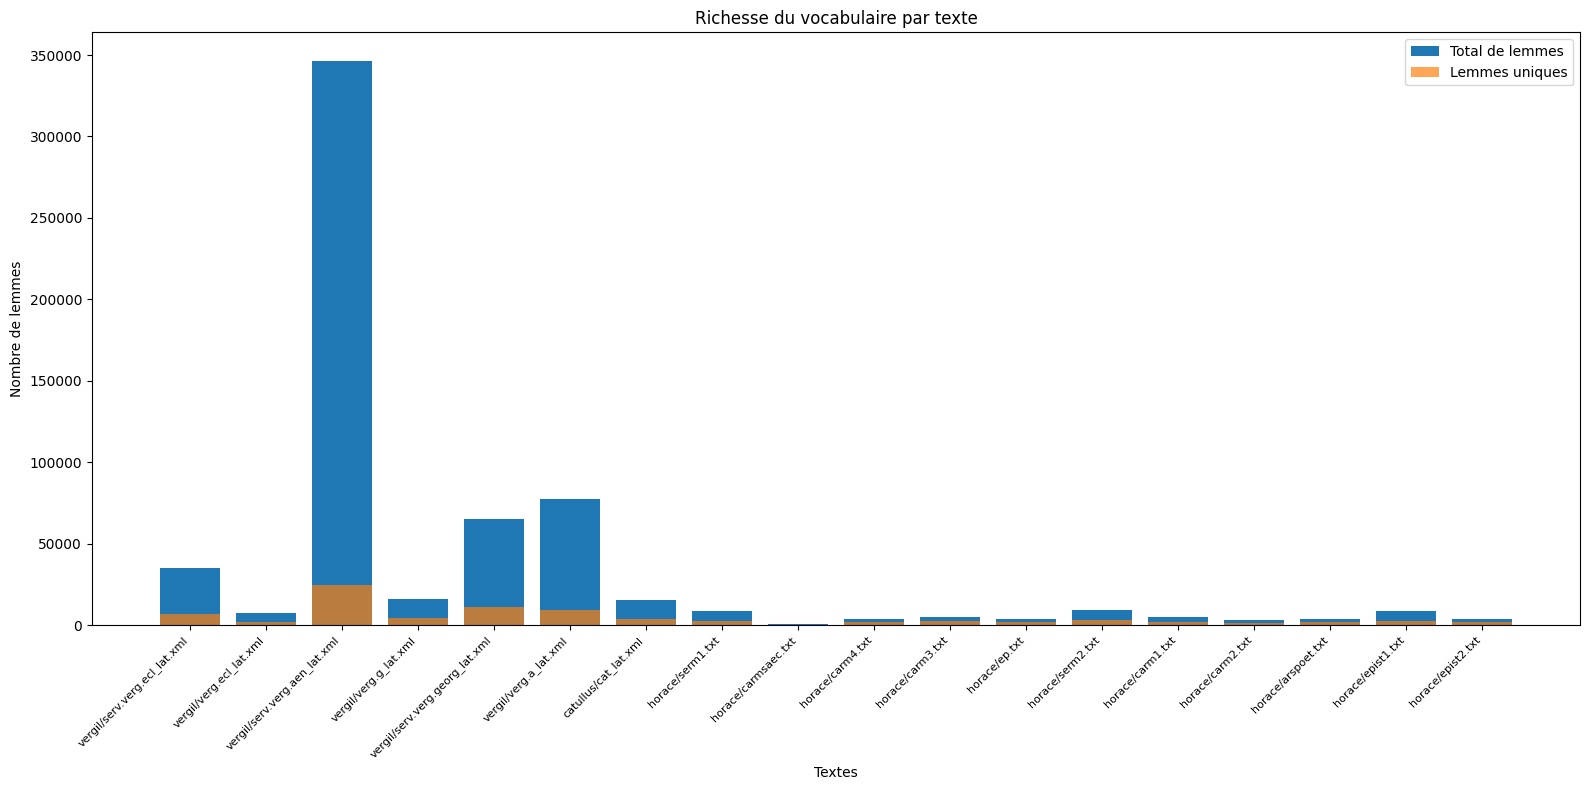

In [61]:
plt.figure(figsize=(16, 8))
plt.bar(index, totals, label='Total de lemmes')
plt.bar(index, uniques, label='Lemmes uniques', alpha=0.7)
plt.xlabel('Textes')
plt.ylabel('Nombre de lemmes')

plt.xticks(index, fichiers, rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=10)
plt.legend(fontsize=10)
plt.title('Richesse du vocabulaire par texte')
plt.tight_layout()
plt.savefig("richesse_vocabulaire.svg", format="svg")
plt.show()

In [84]:
def detect_auteur(path):
    import os
    base = os.path.basename(path)
    if base.startswith("serv."):
        return "servius"
    return path.split(os.sep)[0]

In [85]:
import pandas as pd
import numpy as np

df = pd.DataFrame(resultats, columns=["texte", "total", "uniques"])
df["ttr"] = df["uniques"] / df["total"]
df["log_total"] = np.log10(df["total"])
df["log_uniques"] = np.log10(df["uniques"])
df["auteur"] = df["texte"].apply(lambda p: p.split(os.sep)[0])
df["auteur"] = df["texte"].apply(detect_auteur)
df["auteur"].unique()

array(['servius', 'vergil', 'catullus', 'horace'], dtype=object)

In [97]:
df["log_total"] = np.log10(df["total"])
df["log_uniques"] = np.log10(df["uniques"])

beta, logK = np.polyfit(df["log_total"], df["log_uniques"], 1)
print("beta =", beta, "logK =", logK)

beta = 0.6322850729333243 logK = 0.9438059601093176


In [98]:
df["richesse_norm"] = df["uniques"] / (df["total"] ** beta)
df["richesse_norm"] = df["richesse_norm"] / df["richesse_norm"].mean()

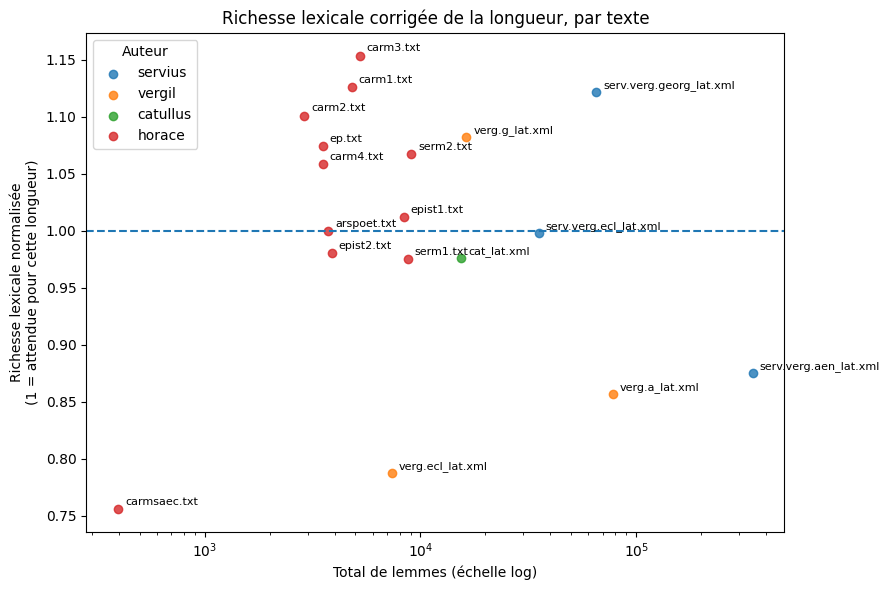

In [100]:
plt.figure(figsize=(9, 6))

for auteur in df["auteur"].unique():
    sub = df[df["auteur"] == auteur]
    plt.scatter(sub["total"], sub["richesse_norm"], label=auteur, alpha=0.8)

plt.xscale("log")
plt.axhline(1.0, linestyle="--")

plt.xlabel("Total de lemmes (échelle log)")
plt.ylabel("Richesse lexicale normalisée\n(1 = attendue pour cette longueur)")
plt.title("Richesse lexicale corrigée de la longueur, par texte")

for _, row in df.iterrows():
    x = row["total"]
    y = row["richesse_norm"]
    label = os.path.basename(row["texte"])
    plt.annotate(
        label,
        (x, y),
        textcoords="offset points",
        xytext=(5, 3),
        fontsize=8,
    )

plt.legend(title="Auteur")
plt.tight_layout()
plt.show()

/tmp/ipython-input-2425421798.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=auteurs)


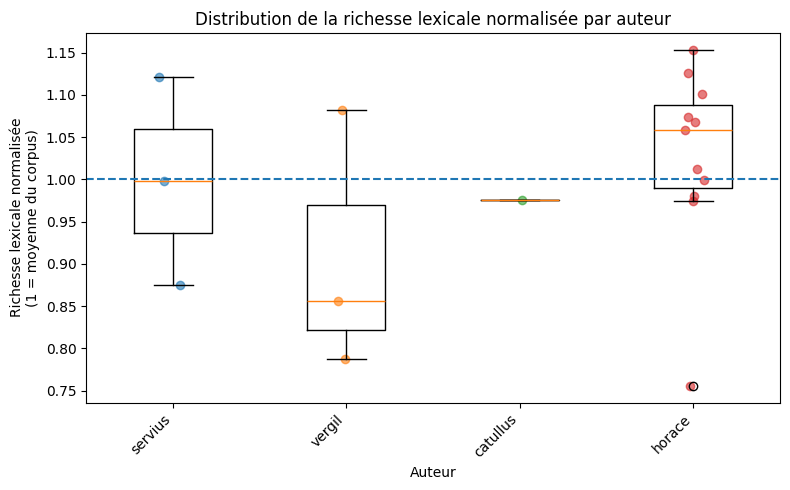

In [101]:
auteurs = df["auteur"].unique()
data = [df[df["auteur"] == a]["richesse_norm"] for a in auteurs]

plt.figure(figsize=(8, 5))
plt.boxplot(data, labels=auteurs)

for i, a in enumerate(auteurs, start=1):
    sub = df[df["auteur"] == a]
    x_jitter = np.random.normal(loc=i, scale=0.03, size=len(sub))
    plt.scatter(x_jitter, sub["richesse_norm"], alpha=0.6)

plt.axhline(1.0, linestyle="--")

plt.ylabel("Richesse lexicale normalisée\n(1 = moyenne du corpus)")
plt.xlabel("Auteur")
plt.title("Distribution de la richesse lexicale normalisée par auteur")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

Axe Y: richesse_norm a été construite pour que :

= à 1, richesse moyenne du corpus, à longueur donnée.

supérieur à 1, texte plus riche que la moyenne pour sa longueur.

< 1, texte moins riche que la moyenne pour sa longueur.

La ligne pointillée est le niveau moyen (1).

Chaque boîte = la distribution des textes d'un auteur :



*   trait orange = médiane,
*   boîte = quartiles (50 % des textes),
*   moustaches + points = dispersion et éventuels intrus.